In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [5]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [6]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [7]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    """Calculate the loss using either MSE or MAE.

    Args:
        y: shape=(N, )
        tx: shape=(N,2)
        w: shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    N = y.shape[0]
    e = y - tx.dot(w)
    loss = 1 / (2 * N) * e.T.dot(e)
    return loss

In [8]:
compute_loss(y, tx, np.array([1,2]))

2694.4833658870834

# 2. Grid Search

Fill in the function `grid_search()` below:

In [9]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))

    for idx_w0 in range(len(grid_w0)):
        for idx_w1 in range(len(grid_w1)):
            losses[idx_w0][idx_w1] = compute_loss(y, tx, np.array([grid_w0[idx_w0], grid_w1[idx_w1]]))
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.497 seconds


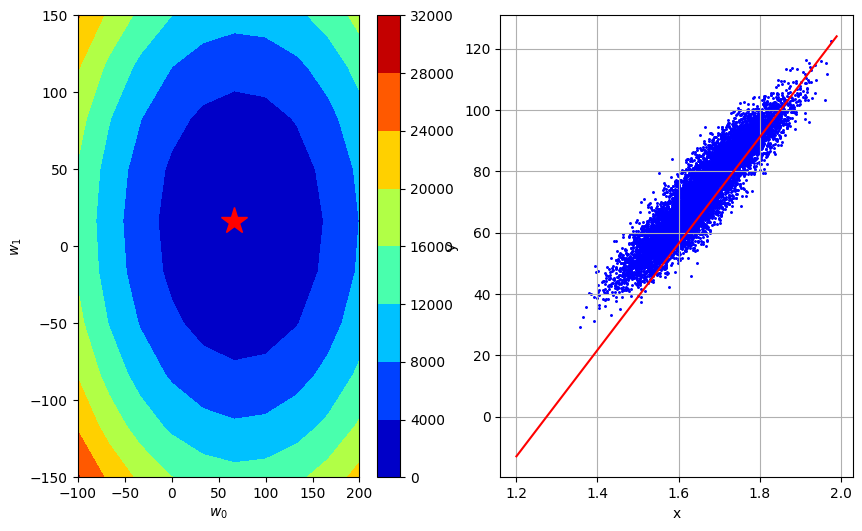

In [10]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot_10")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [11]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    N = y.shape[0]
    #print("tx.shape:", tx.shape)
    #print("w.shape:", w.shape)
    e = y - tx.dot(w)
    #print("e.shape:", e.shape)
    
    gradient = (-1 / N) * tx.T.dot(e)
    return gradient

In [12]:
m100_20 = compute_gradient(y, tx, np.array([100,20]))
m50_10 = compute_gradient(y, tx, np.array([50,10]))
norm100_20 = np.linalg.norm(m100_20)
norm50_10 = np.linalg.norm(m50_10)
print(f"gradient for wT = (100,20): {m100_20}, norm: {norm100_20}")
print(f"gradient for wT = (50,10): {m50_10}, norm: {norm50_10}")

gradient for wT = (100,20): [26.706078    6.52028757], norm: 27.490521129292496
gradient for wT = (50,10): [-23.293922    -3.47971243], norm: 23.552392678247728


Please fill in the functions `gradient_descent` below:

In [13]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute gradient and loss
        loss = compute_loss(y, tx, w)
        gradients = compute_gradient(y, tx, w)
        
        # update w by gradient    
        w = w - gamma * gradients
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [14]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.236712759168, w0=7.32939220021052, w1=1.3479712434988977
GD iter. 1/49: loss=2264.635056030003, w0=13.925845180399987, w1=2.5611453626479044
GD iter. 2/49: loss=1837.27771407938, w0=19.862652862570506, w1=3.653002069882012
GD iter. 3/49: loss=1491.1182670993758, w0=25.205779776523975, w1=4.63567310639271
GD iter. 4/49: loss=1210.729115045572, w0=30.014593999082095, w1=5.520077039252339
GD iter. 5/49: loss=983.613901881991, w0=34.3425267993844, w1=6.316040578826005
GD iter. 6/49: loss=799.6505792194903, w0=38.237666319656476, w1=7.032407764442305
GD iter. 7/49: loss=650.640287862865, w0=41.74329188790135, w1=7.677138231496976
GD iter. 8/49: loss=529.9419518639982, w0=44.89835489932173, w1=8.25739565184618
GD iter. 9/49: loss=432.1762997049161, w0=47.737911609600076, w1=8.779627330160462
GD iter. 10/49: loss=352.9861214560597, w0=50.29351264885059, w1=9.249635840643318
GD iter. 11/49: loss=288.842077074486, w0=52.59355358417605, w1=9.672643500077887
GD iter. 12/4

# Time Visualization

In [15]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [16]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    B = y.shape[0]
    gradients = np.zeros((B, 2))
    for idx in range(B):
        gradients[idx] = compute_gradient(np.array([y[idx]]), np.array([tx[idx, :]]), w)
    return np.average(gradients, axis=0)


def compute_stoch_gradient_eff(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    B = y.shape[0]
    gradients = compute_gradient(y, tx, w)
    return gradients

def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    # Get batched data
    iter = 0
    for batched_y, batched_tx in batch_iter(y, tx, batch_size, max_iters):
        # Get gradient
        gradient = compute_stoch_gradient(batched_y, batched_tx, w)
        
        # Stochastic Gradient Descent
        w = w - gamma * gradient
        loss = compute_loss(y, tx, w)
        
        # Track losses and weights histories
        losses.append(loss)
        ws.append(w)

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )        
        )
        iter += 1
    return losses, ws


def stochastic_gradient_descent_eff(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    # Get batched data
    iter = 0
    for batched_y, batched_tx in batch_iter(y, tx, batch_size, max_iters):
        # Get gradient
        gradient = compute_stoch_gradient_eff(batched_y, batched_tx, w)
        
        # Stochastic Gradient Descent
        w = w - gamma * gradient
        loss = compute_loss(y, tx, w)
        
        # Track losses and weights histories
        losses.append(loss)
        ws.append(w)

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )        
        )
        iter += 1
    return losses, ws

In [17]:
compute_stoch_gradient(y, tx, np.array([1, 2]))

array([-72.293922  , -11.47971243])

In [18]:
compute_stoch_gradient_eff(y, tx, np.array([1, 2]))

array([-72.293922  , -11.47971243])

In [19]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2602.320802834684, w0=4.979855251077027, w1=-9.038238490167988
SGD iter. 1/49: loss=2518.5663458642716, w0=7.924011480285464, w1=-13.596766552504338
SGD iter. 2/49: loss=2235.5807685783916, w0=13.432707582222875, w1=-15.795272955203744
SGD iter. 3/49: loss=1423.7309527043749, w0=23.095335022584415, w1=-3.7479396084723593
SGD iter. 4/49: loss=1350.232695135909, w0=26.071888544593776, w1=-7.491056999436422
SGD iter. 5/49: loss=1123.0274699660588, w0=31.050421671538956, w1=-7.275283204998724
SGD iter. 6/49: loss=899.9101714970552, w0=36.26026034039439, w1=-6.4591057642519765
SGD iter. 7/49: loss=764.5523357764288, w0=40.22307897983592, w1=-6.6362572809263005
SGD iter. 8/49: loss=401.71879631283997, w0=46.86527531484599, w1=4.866208434406887
SGD iter. 9/49: loss=355.28954977512535, w0=48.79964998524861, w1=4.544503306108578
SGD iter. 10/49: loss=255.47524320194816, w0=51.99098950481208, w1=8.34514549297624
SGD iter. 11/49: loss=187.30163006954137, w0=54.77646421592605,

In [20]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent_eff(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2168.348012570423, w0=8.250307578378374, w1=4.80489416019242
SGD iter. 1/49: loss=1670.5135964042627, w0=15.805632272743377, w1=15.793143018304583
SGD iter. 2/49: loss=1389.1498068108415, w0=21.102314771209105, w1=18.333986071682663
SGD iter. 3/49: loss=1142.5262383129543, w0=26.53788388830033, w1=21.735231848610226
SGD iter. 4/49: loss=903.062115459786, w0=31.886348745806064, w1=21.2749245684806
SGD iter. 5/49: loss=771.848883499654, w0=35.593271009303585, w1=23.049817240089954
SGD iter. 6/49: loss=760.6860464128762, w0=36.770191496776405, w1=25.994400887451935
SGD iter. 7/49: loss=521.1742711842046, w0=41.85959140665464, w1=18.323226308890025
SGD iter. 8/49: loss=458.7369888456416, w0=44.302401030826346, w1=20.276322893557566
SGD iter. 9/49: loss=417.3585424873315, w0=46.67255887923918, w1=23.23923776758148
SGD iter. 10/49: loss=323.86821718598765, w0=49.680653623274864, w1=21.185438559349286
SGD iter. 11/49: loss=271.09663772605927, w0=52.29520396449535, w1=21.8

In [21]:
print(len(sgd_ws))
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

51


interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [22]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
height, weight, gender = load_data(sub_sample=True, add_outlier=True)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [23]:
y.shape, tx.shape

((202,), (202, 2))

In [24]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.835114535854, w0=51.847464098448484, w1=7.724426406192441
GD iter. 1/49: loss=318.28212470159497, w0=67.401703327983, w1=10.041754328050121
GD iter. 2/49: loss=88.6423556165126, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574594
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
GD iter. 6/49: loss=65.93222021235334, w0=74.05160722578589, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889339, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225756, w1=11.034889001593537
GD iter

In [25]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [26]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    
    N = y.shape[0]
    e = y - tx.dot(w)
    differentials = np.zeros(e.shape)
        
    for i in range(len(e)):
        if e[i] < 0:
            differentials[i] = -1.0
        elif e[i] == 0:
            differentials[i] = np.random.uniform(-1.0, 1.0)  # getting any subgradient for when e == 0, since all lines for y = c, with c being any value between -1.0 and 1.0 is considered a subgradient of the absolute function
        else:  # e[i] > 0
            differentials[i] = 1.0
    #print("subgradient shape:", differentials.shape)

    return -(1/N)*differentials.dot(tx)
    

In [27]:
s = compute_subgradient_mae(y, tx, np.array([1,2]))
print("subgradient:", s)

subgradient: [-1.00000000e+00 -1.25092456e-15]


In [28]:
def compute_mae_loss(y, tx, w):
    N = y.shape[0]
    e = y - tx.dot(w)
    return np.absolute((1 / N) * np.sum(e))

def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute subgradient
        subgradient = compute_subgradient_mae(y, tx, w)
        
        # Compute loss
        loss = compute_mae_loss(y, tx, w)
        
        # Update w with subgradient
        w = w - gamma * subgradient

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [29]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=8.756471895211877e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=1.7512943790423754e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.0999999999999996, w1=2.626941568563563e-15
SubGD iter. 3/499: loss=71.96780585492637, w0=2.8, w1=3.502588758084751e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=4.378235947605939e-15
SubGD iter. 5/499: loss=70.56780585492639, w0=4.2, w1=5.253883137127127e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=6.1295303266483146e-15
SubGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=7.0051775161695025e-15
SubGD iter. 8/499: loss=68.46780585492638, w0=6.300000000000001, w1=7.88082470569069e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=8.756471895211878e-15
SubGD iter. 10/499: loss=67.06780585492639, w0=7.700000000000001, w1=9.632119084733065e-15
SubGD iter. 11/499: loss=66.36780585492637, w0=8.4, w1=1.0507766274254253e-14
SubGD iter.

In [30]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [31]:
def compute_stoch_subgradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    return compute_subgradient_mae(y, tx, w)

def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    n_iter = 0

    for batched_y, batched_x in batch_iter(y, tx, batch_size, max_iters):
        
        # Compute subgradient and loss
        subgradient = compute_stoch_subgradient(y, tx, w)
        loss = compute_mae_loss(y, tx, w)
        
        
        # Update weights with computed subgradients
        w = w - gamma * subgradient

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
        
        # Update weights and loss history
        ws.append(w)
        losses.append(loss)
        n_iter += 1
    return losses, ws

In [32]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=8.756471895211877e-16
SubSGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=1.7512943790423754e-15
SubSGD iter. 2/499: loss=72.66780585492637, w0=2.0999999999999996, w1=2.626941568563563e-15
SubSGD iter. 3/499: loss=71.96780585492637, w0=2.8, w1=3.502588758084751e-15
SubSGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=4.378235947605939e-15
SubSGD iter. 5/499: loss=70.56780585492639, w0=4.2, w1=5.253883137127127e-15
SubSGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=6.1295303266483146e-15
SubSGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=7.0051775161695025e-15
SubSGD iter. 8/499: loss=68.46780585492638, w0=6.300000000000001, w1=7.88082470569069e-15
SubSGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=8.756471895211878e-15
SubSGD iter. 10/499: loss=67.06780585492639, w0=7.700000000000001, w1=9.632119084733065e-15
SubSGD iter. 11/499: loss=66.36780585492637, w0=8.4, w1=1.0507766274254253e-14

In [33]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=500, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>